### Create an ML algorithm to classify the planets as Candidate/False positive/Confirmed etc based on the  column “koi_disposition”.

In [1]:
import warnings
warnings.simplefilter('ignore')

In [91]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fast_ml.feature_selection import get_constant_features
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,make_scorer,confusion_matrix
from lazypredict.Supervised import LazyClassifier

%matplotlib inline

In [3]:
df = pd.read_csv('modified.csv')
df

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.00,0,0,0,0,...,-81.00,4.47,0.06,-0.10,0.93,0.10,-0.06,291.93,48.14,15.35
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.97,0,0,0,0,...,-81.00,4.47,0.06,-0.10,0.93,0.10,-0.06,291.93,48.14,15.35
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.00,0,0,0,0,...,-176.00,4.54,0.04,-0.18,0.87,0.23,-0.08,297.00,48.13,15.44
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.00,0,1,0,0,...,-174.00,4.56,0.05,-0.17,0.79,0.20,-0.07,285.53,48.29,15.60
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.00,0,0,0,0,...,-211.00,4.44,0.07,-0.21,1.05,0.33,-0.13,288.75,48.23,15.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,10090151,K07985.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.00,0,1,1,0,...,-166.00,4.53,0.04,-0.20,0.90,0.24,-0.08,297.19,47.09,14.08
9560,10128825,K07986.01,NaN,CANDIDATE,CANDIDATE,0.50,0,0,0,0,...,-220.00,4.44,0.06,-0.22,1.03,0.34,-0.11,286.51,47.16,14.76
9561,10147276,K07987.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.02,0,0,1,0,...,-236.00,4.45,0.06,-0.22,1.04,0.34,-0.11,294.16,47.18,15.38
9562,10155286,K07988.01,NaN,CANDIDATE,CANDIDATE,0.09,0,0,0,0,...,-128.00,2.99,0.03,-0.03,7.82,0.22,-1.90,296.76,47.15,11.00


In [4]:
df.isna().sum()

kepid                   0
kepoi_name              0
kepler_name          7204
koi_disposition         0
koi_pdisposition        0
koi_score            1510
koi_fpflag_nt           0
koi_fpflag_ss           0
koi_fpflag_co           0
koi_fpflag_ec           0
koi_period              0
koi_period_err1       454
koi_period_err2       454
koi_time0bk             0
koi_time0bk_err1      454
koi_time0bk_err2      454
koi_impact            363
koi_impact_err1       454
koi_impact_err2       454
koi_duration            0
koi_duration_err1     454
koi_duration_err2     454
koi_depth             363
koi_depth_err1        454
koi_depth_err2        454
koi_prad              363
koi_prad_err1         363
koi_prad_err2         363
koi_teq               363
koi_teq_err1         9564
koi_teq_err2         9564
koi_insol             321
koi_insol_err1        321
koi_insol_err2        321
koi_model_snr         363
koi_tce_plnt_num      346
koi_tce_delivname     346
koi_steff             363
koi_steff_er

In [5]:
df['koi_disposition'].unique()
#multi-class classification

array(['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE'], dtype=object)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2360 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9110 non-null   float64
 12  koi_period_err2    9110 non-null   float64
 13  koi_time0bk        9564 non-null   float64
 14  koi_time0bk_err1   9110 non-null   float64
 15  koi_time0bk_err2   9110 non-null   float64
 16  koi_impact         9201 

In [7]:
# dropping columns with all/many null values
print("Before = ",len(df.columns))
df.drop(columns = ['koi_teq_err1','koi_teq_err2'],axis=1,inplace=True)
print("After = ",len(df.columns))

Before =  49
After =  47


In [8]:
len(df['kepler_name'].unique())

2361

## Dividing Dataset into X and y

In [9]:
X = df.drop(columns = ['koi_disposition'],axis=1)
y = df['koi_disposition']

In [10]:
X

,kepid,kepoi_name,kepler_name,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CANDIDATE,1.00,0,0,0,0,9.49,...,-81.00,4.47,0.06,-0.10,0.93,0.10,-0.06,291.93,48.14,15.35
1,10797460,K00752.02,Kepler-227 c,CANDIDATE,0.97,0,0,0,0,54.42,...,-81.00,4.47,0.06,-0.10,0.93,0.10,-0.06,291.93,48.14,15.35
2,10811496,K00753.01,NaN,CANDIDATE,0.00,0,0,0,0,19.90,...,-176.00,4.54,0.04,-0.18,0.87,0.23,-0.08,297.00,48.13,15.44
3,10848459,K00754.01,NaN,FALSE POSITIVE,0.00,0,1,0,0,1.74,...,-174.00,4.56,0.05,-0.17,0.79,0.20,-0.07,285.53,48.29,15.60
4,10854555,K00755.01,Kepler-664 b,CANDIDATE,1.00,0,0,0,0,2.53,...,-211.00,4.44,0.07,-0.21,1.05,0.33,-0.13,288.75,48.23,15.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,10090151,K07985.01,NaN,FALSE POSITIVE,0.00,0,1,1,0,0.53,...,-166.00,4.53,0.04,-0.20,0.90,0.24,-0.08,297.19,47.09,14.08
9560,10128825,K07986.01,NaN,CANDIDATE,0.50,0,0,0,0,1.74,...,-220.00,4.44,0.06,-0.22,1.03,0.34,-0.11,286.51,47.16,14.76
9561,10147276,K07987.01,NaN,FALSE POSITIVE,0.02,0,0,1,0,0.68,...,-236.00,4.45,0.06,-0.22,1.04,0.34,-0.11,294.16,47.18,15.38
9562,10155286,K07988.01,NaN,CANDIDATE,0.09,0,0,0,0,333.49,...,-128.00,2.99,0.03,-0.03,7.82,0.22,-1.90,296.76,47.15,11.00


In [11]:
y

0            CONFIRMED
1            CONFIRMED
2            CANDIDATE
3       FALSE POSITIVE
4            CONFIRMED
             ...      
9559    FALSE POSITIVE
9560         CANDIDATE
9561    FALSE POSITIVE
9562         CANDIDATE
9563    FALSE POSITIVE
Name: koi_disposition, Length: 9564, dtype: object

### Checking Imbalanced Dataset

In [12]:
y.value_counts()

FALSE POSITIVE    4840
CANDIDATE         2366
CONFIRMED         2358
Name: koi_disposition, dtype: int64

### Duplicate Rows/Columns

In [13]:
X.duplicated().sum()

0

In [14]:
X.T.duplicated().sum()

0

### Constant/Quasi-Constant Features

In [15]:
get_constant_features(X)

,Desc,Var,Value,Perc


## Filling the Null values in Categorical Columns

In [16]:
X.dtypes[df.dtypes=='object']

kepoi_name           object
kepler_name          object
koi_pdisposition     object
koi_tce_delivname    object
dtype: object

In [17]:
X[['kepoi_name','kepler_name','koi_pdisposition','koi_tce_delivname']].isna().sum()

kepoi_name              0
kepler_name          7204
koi_pdisposition        0
koi_tce_delivname     346
dtype: int64

In [18]:
X['kepler_name'].fillna(value='unknown',inplace=True)

In [19]:
X['koi_tce_delivname'].value_counts()

q1_q17_dr25_tce    8054
q1_q16_tce          796
q1_q17_dr24_tce     368
Name: koi_tce_delivname, dtype: int64

In [20]:
X['koi_tce_delivname'].fillna(X['koi_tce_delivname'].mode()[0], inplace=True)

In [21]:
X[['kepoi_name','kepler_name','koi_pdisposition','koi_tce_delivname']].isna().sum()

kepoi_name           0
kepler_name          0
koi_pdisposition     0
koi_tce_delivname    0
dtype: int64

In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        9564 non-null   object 
 3   koi_pdisposition   9564 non-null   object 
 4   koi_score          8054 non-null   float64
 5   koi_fpflag_nt      9564 non-null   int64  
 6   koi_fpflag_ss      9564 non-null   int64  
 7   koi_fpflag_co      9564 non-null   int64  
 8   koi_fpflag_ec      9564 non-null   int64  
 9   koi_period         9564 non-null   float64
 10  koi_period_err1    9110 non-null   float64
 11  koi_period_err2    9110 non-null   float64
 12  koi_time0bk        9564 non-null   float64
 13  koi_time0bk_err1   9110 non-null   float64
 14  koi_time0bk_err2   9110 non-null   float64
 15  koi_impact         9201 non-null   float64
 16  koi_impact_err1    9110 

## Imputing Null values of Numerical Variables

In [23]:
X.dtypes[X.dtypes!='object']

kepid                  int64
koi_score            float64
koi_fpflag_nt          int64
koi_fpflag_ss          int64
koi_fpflag_co          int64
koi_fpflag_ec          int64
koi_period           float64
koi_period_err1      float64
koi_period_err2      float64
koi_time0bk          float64
koi_time0bk_err1     float64
koi_time0bk_err2     float64
koi_impact           float64
koi_impact_err1      float64
koi_impact_err2      float64
koi_duration         float64
koi_duration_err1    float64
koi_duration_err2    float64
koi_depth            float64
koi_depth_err1       float64
koi_depth_err2       float64
koi_prad             float64
koi_prad_err1        float64
koi_prad_err2        float64
koi_teq              float64
koi_insol            float64
koi_insol_err1       float64
koi_insol_err2       float64
koi_model_snr        float64
koi_tce_plnt_num     float64
koi_steff            float64
koi_steff_err1       float64
koi_steff_err2       float64
koi_slogg            float64
koi_slogg_err1

In [24]:
cols = ['kepoi_name','kepler_name','koi_pdisposition','koi_tce_delivname']
numerical = X.drop(columns = cols)
num_cols = numerical.columns

In [25]:
num_cols

Index(['kepid', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2',
       'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact',
       'koi_impact_err1', 'koi_impact_err2', 'koi_duration',
       'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1',
       'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2',
       'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1',
       'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2',
       'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec',
       'koi_kepmag'],
      dtype='object')

In [26]:
imputer = KNNImputer(n_neighbors=10,weights='distance')

In [27]:
X[num_cols] = imputer.fit_transform(X[num_cols])

In [28]:
X.isna().sum()

kepid                0
kepoi_name           0
kepler_name          0
koi_pdisposition     0
koi_score            0
koi_fpflag_nt        0
koi_fpflag_ss        0
koi_fpflag_co        0
koi_fpflag_ec        0
koi_period           0
koi_period_err1      0
koi_period_err2      0
koi_time0bk          0
koi_time0bk_err1     0
koi_time0bk_err2     0
koi_impact           0
koi_impact_err1      0
koi_impact_err2      0
koi_duration         0
koi_duration_err1    0
koi_duration_err2    0
koi_depth            0
koi_depth_err1       0
koi_depth_err2       0
koi_prad             0
koi_prad_err1        0
koi_prad_err2        0
koi_teq              0
koi_insol            0
koi_insol_err1       0
koi_insol_err2       0
koi_model_snr        0
koi_tce_plnt_num     0
koi_tce_delivname    0
koi_steff            0
koi_steff_err1       0
koi_steff_err2       0
koi_slogg            0
koi_slogg_err1       0
koi_slogg_err2       0
koi_srad             0
koi_srad_err1        0
koi_srad_err2        0
ra         

## Encoding Categorical Variables

In [29]:
X.dtypes[X.dtypes=='object']

kepoi_name           object
kepler_name          object
koi_pdisposition     object
koi_tce_delivname    object
dtype: object

In [30]:
X['kepoi_name'].nunique() #binary encoding

9564

In [31]:
X['kepler_name'].nunique() # label encoding

2361

In [32]:
X['koi_pdisposition'].nunique() #one-hot encoding

2

In [33]:
X['koi_tce_delivname'].nunique() #one-hot encoding

3

In [34]:
X['kepoi_name'] = LabelEncoder().fit_transform(X['kepoi_name'])

X['kepler_name'] = LabelEncoder().fit_transform(X['kepler_name'])

X['False Positive'] = pd.get_dummies(X['koi_pdisposition'],drop_first=True)

X[['q1_q17_dr24_tce', 'q1_q17_dr25_tce']] = pd.get_dummies(X['koi_tce_delivname'],drop_first=True)


X.drop(columns = ['koi_pdisposition','koi_tce_delivname'],axis=1,inplace=True)

In [35]:
X

,kepid,kepoi_name,kepler_name,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,...,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,False Positive,q1_q17_dr24_tce,q1_q17_dr25_tce
0,10797460.00,1080,1090,1.00,0.00,0.00,0.00,0.00,9.49,0.00,...,-0.10,0.93,0.10,-0.06,291.93,48.14,15.35,0,0,1
1,10797460.00,1081,1091,0.97,0.00,0.00,0.00,0.00,54.42,0.00,...,-0.10,0.93,0.10,-0.06,291.93,48.14,15.35,0,0,1
2,10811496.00,1082,2360,0.00,0.00,0.00,0.00,0.00,19.90,0.00,...,-0.18,0.87,0.23,-0.08,297.00,48.13,15.44,0,0,1
3,10848459.00,1083,2360,0.00,0.00,1.00,0.00,0.00,1.74,0.00,...,-0.17,0.79,0.20,-0.07,285.53,48.29,15.60,1,0,1
4,10854555.00,1084,1929,1.00,0.00,0.00,0.00,0.00,2.53,0.00,...,-0.21,1.05,0.33,-0.13,288.75,48.23,15.51,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,10090151.00,9249,2360,0.00,0.00,1.00,1.00,0.00,0.53,0.00,...,-0.20,0.90,0.24,-0.08,297.19,47.09,14.08,1,0,1
9560,10128825.00,9250,2360,0.50,0.00,0.00,0.00,0.00,1.74,0.00,...,-0.22,1.03,0.34,-0.11,286.51,47.16,14.76,0,0,1
9561,10147276.00,9251,2360,0.02,0.00,0.00,1.00,0.00,0.68,0.00,...,-0.22,1.04,0.34,-0.11,294.16,47.18,15.38,1,0,1
9562,10155286.00,9252,2360,0.09,0.00,0.00,0.00,0.00,333.49,0.00,...,-0.03,7.82,0.22,-1.90,296.76,47.15,11.00,0,0,1


## Outliers

kepid                  AxesSubplot(0.125,0.814746;0.0945122x0.0652542)
koi_score            AxesSubplot(0.238415,0.814746;0.0945122x0.0652...
koi_fpflag_nt        AxesSubplot(0.351829,0.814746;0.0945122x0.0652...
koi_fpflag_ss        AxesSubplot(0.465244,0.814746;0.0945122x0.0652...
koi_fpflag_co        AxesSubplot(0.578659,0.814746;0.0945122x0.0652...
koi_fpflag_ec        AxesSubplot(0.692073,0.814746;0.0945122x0.0652...
koi_period           AxesSubplot(0.805488,0.814746;0.0945122x0.0652...
koi_period_err1        AxesSubplot(0.125,0.736441;0.0945122x0.0652542)
koi_period_err2      AxesSubplot(0.238415,0.736441;0.0945122x0.0652...
koi_time0bk          AxesSubplot(0.351829,0.736441;0.0945122x0.0652...
koi_time0bk_err1     AxesSubplot(0.465244,0.736441;0.0945122x0.0652...
koi_time0bk_err2     AxesSubplot(0.578659,0.736441;0.0945122x0.0652...
koi_impact           AxesSubplot(0.692073,0.736441;0.0945122x0.0652...
koi_impact_err1      AxesSubplot(0.805488,0.736441;0.0945122x0.0652...
koi_im

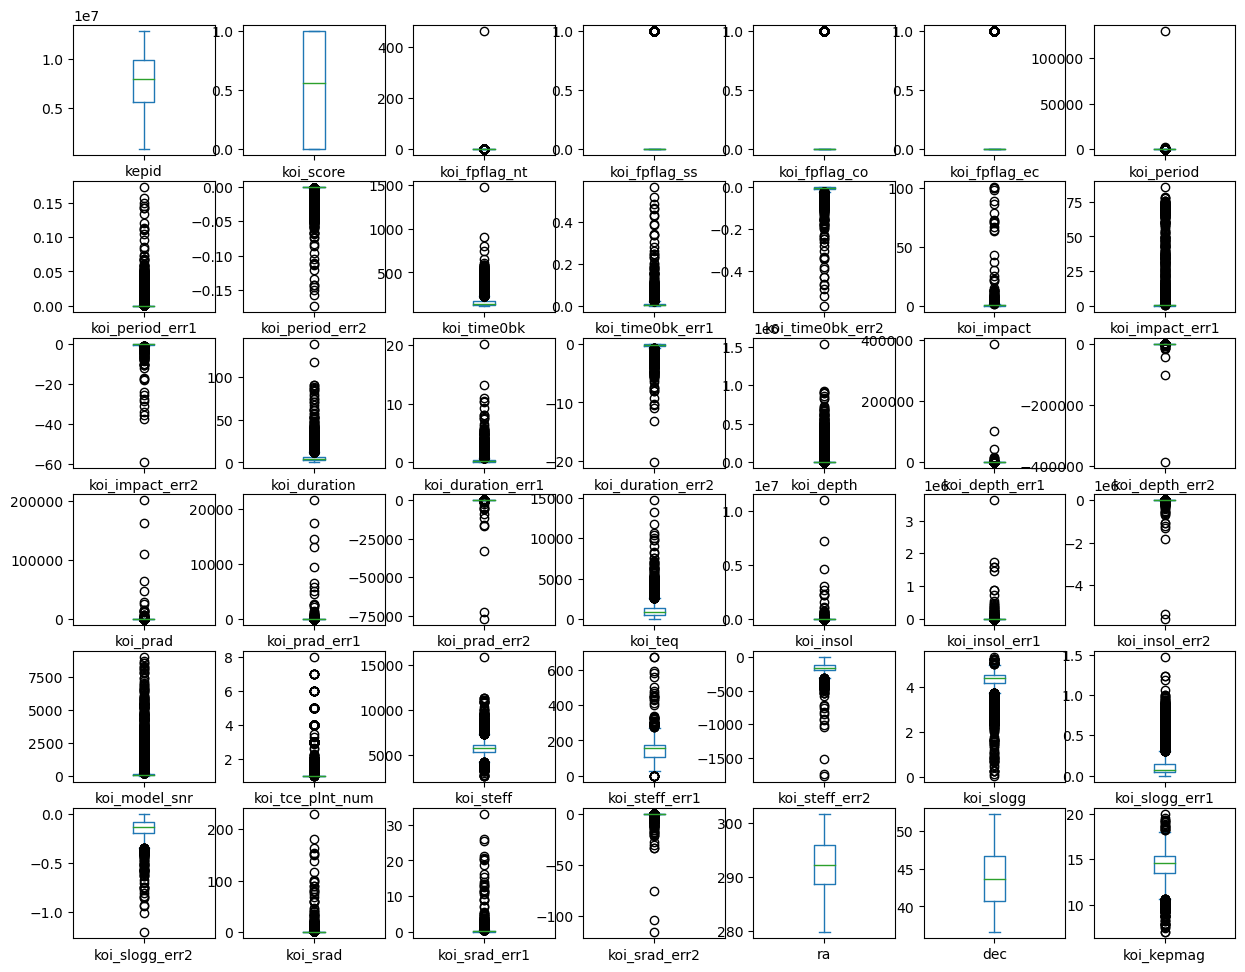

In [36]:
X[num_cols].plot(kind="box",subplots=True,layout=(10,7),figsize=(15,20))

### Funtion to remove outliers

In [37]:
num_cols

Index(['kepid', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2',
       'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact',
       'koi_impact_err1', 'koi_impact_err2', 'koi_duration',
       'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1',
       'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2',
       'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1',
       'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2',
       'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec',
       'koi_kepmag'],
      dtype='object')

In [38]:
def remove_outliers(column):
    q1,q3 = np.percentile(column, [25,75])
    IQR = q3 - q1
    upper_fence = q3 + 1.5 * IQR
    lower_fence = q1 - 1.5 * IQR
    
    column = np.where(column>=upper_fence,
                      upper_fence,
                      np.where(column<=lower_fence,
                               lower_fence,
                               column)
                     )
    return column

In [39]:
X['koi_kepmag'] = remove_outliers(X['koi_kepmag'])

X['koi_slogg_err2'] = remove_outliers(X['koi_slogg_err2'])

X['koi_slogg_err1'] = remove_outliers(X['koi_slogg_err1'])

X['koi_slogg'] = remove_outliers(X['koi_slogg'])

X['koi_steff'] = remove_outliers(X['koi_steff'])

X['koi_steff_err1'] = remove_outliers(X['koi_steff_err1'])

X['koi_steff_err2'] = remove_outliers(X['koi_steff_err2'])

X['koi_teq'] = remove_outliers(X['koi_teq'])

## Feature Selection

<AxesSubplot:>

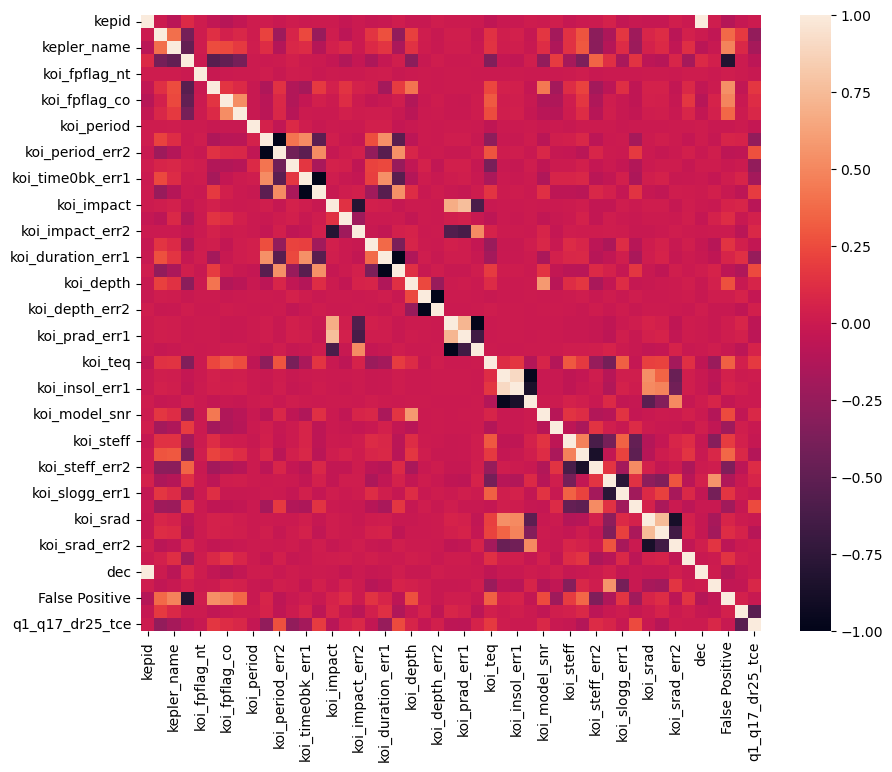

In [40]:
plt.figure(figsize=(10,8))
sns.heatmap(X.corr())

### Information Gain

In [41]:
info_gain = mutual_info_classif(X,y)

<AxesSubplot:>

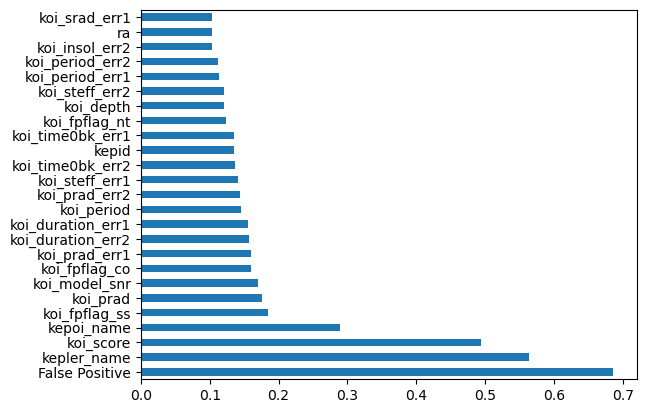

In [42]:
information_gain = pd.Series(info_gain, index= X.columns)
information_gain.nlargest(25).plot(kind='barh')

## Multi-collinearity

In [43]:
Xc = X.copy()

In [44]:
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X,columns = Xc.columns)

In [45]:
X

,kepid,kepoi_name,kepler_name,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,...,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,False Positive,q1_q17_dr24_tce,q1_q17_dr25_tce
0,1.17,-1.34,-1.60,1.11,-0.04,-0.55,-0.50,-0.37,-0.05,-0.26,...,0.60,-0.13,-0.28,0.16,-0.03,1.20,0.80,-1.01,-0.20,0.37
1,1.17,-1.34,-1.60,1.04,-0.04,-0.55,-0.50,-0.37,-0.02,-0.23,...,0.60,-0.13,-0.28,0.16,-0.03,1.20,0.80,-1.01,-0.20,0.37
2,1.18,-1.34,0.48,-1.10,-0.04,-0.55,-0.50,-0.37,-0.04,-0.26,...,-0.45,-0.14,-0.14,0.15,1.04,1.20,0.87,-1.01,-0.20,0.37
3,1.19,-1.34,0.48,-1.10,-0.04,1.82,-0.50,-0.37,-0.06,-0.26,...,-0.34,-0.15,-0.18,0.15,-1.37,1.24,0.99,0.99,-0.20,0.37
4,1.19,-1.34,-0.23,1.11,-0.04,-0.55,-0.50,-0.37,-0.05,-0.26,...,-0.89,-0.11,-0.03,0.12,-0.69,1.23,0.92,-1.01,-0.20,0.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,0.90,1.62,0.48,-1.10,-0.04,1.82,2.02,-0.37,-0.06,-0.26,...,-0.71,-0.14,-0.14,0.15,1.08,0.91,-0.15,0.99,-0.20,0.37
9560,0.92,1.62,0.48,-0.00,-0.04,-0.55,-0.50,-0.37,-0.06,-0.26,...,-1.08,-0.12,-0.02,0.13,-1.16,0.93,0.36,-1.01,-0.20,0.37
9561,0.93,1.62,0.48,-1.06,-0.04,-0.55,2.02,-0.37,-0.06,-0.26,...,-1.08,-0.11,-0.02,0.13,0.44,0.93,0.83,0.99,-0.20,0.37
9562,0.93,1.62,0.48,-0.90,-0.04,-0.55,-0.50,-0.37,0.19,0.26,...,1.50,1.01,-0.15,-0.71,0.99,0.93,-2.45,-1.01,-0.20,0.37


In [46]:
VIF = pd.DataFrame(X.columns,columns=['features'])

In [47]:
VIF['vif'] = [variance_inflation_factor(X,i) for i in range(X.shape[1])]
VIF

,features,vif
0,kepid,80.09
1,kepoi_name,1.67
2,kepler_name,1.52
3,koi_score,4.06
4,koi_fpflag_nt,1.00
5,koi_fpflag_ss,1.99
6,koi_fpflag_co,2.01
7,koi_fpflag_ec,1.51
8,koi_period,1.01
9,koi_period_err1,inf


In [48]:
high_collinearity = VIF.sort_values(by='vif',ascending=False)[:18]['features'].values
X[high_collinearity]

#These columns have a very high multi-collinearity. Therefore, have to drop them.

,koi_period_err2,koi_depth_err2,koi_depth_err1,koi_duration_err2,koi_duration_err1,koi_time0bk_err2,koi_time0bk_err1,koi_period_err1,kepid,dec,koi_prad,koi_prad_err2,koi_insol,koi_insol_err2,koi_srad,koi_insol_err1,koi_srad_err2,koi_steff_err2
0,0.26,0.03,-0.03,0.39,-0.39,0.34,-0.34,-0.26,1.17,1.20,-0.03,0.03,-0.05,0.05,-0.13,-0.07,0.16,1.35
1,0.23,0.02,-0.02,0.34,-0.34,0.28,-0.28,-0.23,1.17,1.20,-0.03,0.03,-0.05,0.05,-0.13,-0.07,0.16,1.35
2,0.26,-0.01,0.01,0.47,-0.47,0.41,-0.41,-0.26,1.18,1.20,-0.03,0.03,-0.05,0.05,-0.14,-0.07,0.15,-0.27
3,0.26,0.03,-0.03,0.51,-0.51,0.43,-0.43,-0.26,1.19,1.24,-0.02,0.03,-0.04,0.04,-0.15,-0.06,0.15,-0.23
4,0.26,0.03,-0.03,0.45,-0.45,0.39,-0.39,-0.26,1.19,1.23,-0.03,0.03,-0.04,0.04,-0.11,-0.05,0.12,-0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,0.26,0.03,-0.03,0.49,-0.49,0.43,-0.43,-0.26,0.90,0.91,-0.02,0.03,-0.02,0.03,-0.14,-0.01,0.15,-0.10
9560,0.26,0.03,-0.03,0.17,-0.17,0.10,-0.10,-0.26,0.92,0.93,-0.03,0.03,-0.04,0.04,-0.12,-0.04,0.13,-1.01
9561,0.26,0.03,-0.03,0.27,-0.27,0.31,-0.31,-0.26,0.93,0.93,-0.03,0.03,-0.01,0.03,-0.11,0.04,0.13,-1.29
9562,-0.26,0.02,-0.02,0.17,-0.17,0.21,-0.21,0.26,0.93,0.93,-0.03,0.02,-0.05,0.05,1.01,-0.07,-0.71,0.55


In [49]:
X.drop(columns = high_collinearity,axis=1,inplace=True)

In [50]:
X

,kepoi_name,kepler_name,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,...,koi_steff_err1,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad_err1,ra,koi_kepmag,False Positive,q1_q17_dr24_tce,q1_q17_dr25_tce
0,-1.34,-1.60,1.11,-0.04,-0.55,-0.50,-0.37,-0.05,0.06,-0.18,...,-1.45,0.42,-0.51,0.60,-0.28,-0.03,0.80,-1.01,-0.20,0.37
1,-1.34,-1.60,1.04,-0.04,-0.55,-0.50,-0.37,-0.02,-0.05,-0.04,...,-1.45,0.42,-0.51,0.60,-0.28,-0.03,0.80,-1.01,-0.20,0.37
2,-1.34,0.48,-1.10,-0.04,-0.55,-0.50,-0.37,-0.04,0.14,0.07,...,0.31,0.71,-0.75,-0.45,-0.14,1.04,0.87,-1.01,-0.20,0.37
3,-1.34,0.48,-1.10,-0.04,1.82,-0.50,-0.37,-0.06,0.06,0.16,...,0.29,0.78,-0.64,-0.34,-0.18,-1.37,0.99,0.99,-0.20,0.37
4,-1.34,-0.23,1.11,-0.04,-0.55,-0.50,-0.37,-0.05,0.08,-0.01,...,0.57,0.32,-0.44,-0.89,-0.03,-0.69,0.92,-1.01,-0.20,0.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,1.62,0.48,-1.10,-0.04,1.82,2.02,-0.37,-0.06,-0.51,0.16,...,-0.12,0.65,-0.85,-0.71,-0.14,1.08,-0.15,0.99,-0.20,0.37
9560,1.62,0.48,-0.00,-0.04,-0.55,-0.50,-0.37,-0.06,-0.49,-0.21,...,0.48,0.34,-0.61,-1.08,-0.02,-1.16,0.36,-1.01,-0.20,0.37
9561,1.62,0.48,-1.06,-0.04,-0.55,2.02,-0.37,-0.06,-0.50,-0.18,...,1.12,0.35,-0.61,-1.08,-0.02,0.44,0.83,0.99,-0.20,0.37
9562,1.62,0.48,-0.90,-0.04,-0.55,-0.50,-0.37,0.19,-0.19,-0.16,...,-2.42,-2.27,-0.91,1.50,-0.15,0.99,-2.45,-1.01,-0.20,0.37


# Model Building

In [51]:
y.unique()

array(['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE'], dtype=object)

### Models - RandomForest, AdaBoost, XGBoost

In [52]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,train_size=0.7,random_state=32)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((6694, 29), (2870, 29), (6694,), (2870,))

### 1. Random Forest

In [53]:
rf = RandomForestClassifier()
rf.fit(Xtrain,ytrain)

RandomForestClassifier()

In [54]:
print("Accuracy = ",accuracy_score(ytest,rf.predict(Xtest)))
print("Precision = ",precision_score(ytest,rf.predict(Xtest),average='macro'))
print("Recall = ",recall_score(ytest,rf.predict(Xtest),average='macro'))
print("F1-Score = ",fbeta_score(ytest,rf.predict(Xtest),beta=1,average='macro'))

Accuracy =  1.0
Precision =  1.0
Recall =  1.0
F1-Score =  1.0


In [55]:
f1_macro = make_scorer(f1_score,average='macro')

In [56]:
rf_test_scores = cross_val_score(rf,Xtest,ytest,cv = StratifiedKFold(10),scoring=f1_macro)
rf_test_scores.mean()

0.9995202843781815

In [88]:
confusion_matrix(ytest,rf.predict(Xtest))

array([[ 685,    0,    0],
       [   0,  703,    0],
       [   0,    0, 1482]], dtype=int64)

#### HYPERPARAMTER TUNING

In [79]:
params = { 'n_estimators' : [100, 150, 200, 250], 
             'criterion' : ['gini', 'entropy'], 
             'max_depth' : range(2, 30, 1), 
             'min_samples_split' : range(2, 30, 1), 
             'min_samples_leaf' : range(2, 30, 1), 
          'max_leaf_nodes' : range(2, 20)
             }

In [80]:
tune = RandomizedSearchCV(rf,params,cv=StratifiedKFold(5),n_jobs=-1,verbose=3)

In [81]:
tune.fit(Xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 30),
                                        'max_leaf_nodes': range(2, 20),
                                        'min_samples_leaf': range(2, 30),
                                        'min_samples_split': range(2, 30),
                                        'n_estimators': [100, 150, 200, 250]},
                   verbose=3)

In [82]:
tune.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=13, max_leaf_nodes=7,
                       min_samples_leaf=10, min_samples_split=28)

In [83]:
rf_tuned = RandomForestClassifier(criterion='entropy', max_depth=13, max_leaf_nodes=7,
                       min_samples_leaf=10, min_samples_split=28)

In [84]:
rf_tuned.fit(Xtrain,ytrain)

RandomForestClassifier(criterion='entropy', max_depth=13, max_leaf_nodes=7,
                       min_samples_leaf=10, min_samples_split=28)

In [85]:
f1_macro = make_scorer(f1_score,average='macro')

rf_tuned_test_scores = cross_val_score(rf_tuned,Xtest,ytest,cv = StratifiedKFold(5),scoring=f1_macro)
rf_tuned_test_scores.mean()

0.9988196637560545

In [87]:
0.9995202843781815 - 0.9988196637560545 # Not tuned RandomForest performing slightly better than tuned
# One potential reason - might be penalizing factors leading to overfitting

0.0007006206221270572

In [90]:
confusion_matrix(ytest,rf_tuned.predict(Xtest))

array([[ 684,    0,    1],
       [   0,  701,    2],
       [   0,    0, 1482]], dtype=int64)

## AdaBoost

In [57]:
ada = AdaBoostClassifier()

In [58]:
ada.fit(Xtrain,ytrain)

AdaBoostClassifier()

In [59]:
print("Accuracy = ",accuracy_score(ytest,ada.predict(Xtest)))
print("Precision = ",precision_score(ytest,ada.predict(Xtest),average='macro'))
print("Recall = ",recall_score(ytest,ada.predict(Xtest),average='macro'))
print("F1-Score = ",fbeta_score(ytest,ada.predict(Xtest),beta=1,average='macro'))

Accuracy =  0.9989547038327526
Precision =  0.9993265993265993
Recall =  0.9985775248933143
F1-Score =  0.9989502008431544


In [60]:
f1_macro = make_scorer(f1_score,average='macro')

ada_test_scores = cross_val_score(ada,Xtest,ytest,cv = StratifiedKFold(10),scoring=f1_macro)
ada_test_scores.mean()

0.9995202843781815

#### HYPERPARAMETER TUNING

In [64]:
params = {'base_estimator':[RandomForestClassifier(),LogisticRegression(),ExtraTreesClassifier()],
          'n_estimators':[100,150,200,300],
          'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.5],
         }

In [65]:
tune = RandomizedSearchCV(ada,params,cv = StratifiedKFold(5),n_jobs=-1,verbose=3)

In [66]:
tune.fit(Xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=AdaBoostClassifier(), n_jobs=-1,
                   param_distributions={'base_estimator': [RandomForestClassifier(),
                                                           LogisticRegression(),
                                                           ExtraTreesClassifier()],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2, 0.5],
                                        'n_estimators': [100, 150, 200, 300]},
                   verbose=3)

In [67]:
tune.best_estimator_

AdaBoostClassifier(base_estimator=RandomForestClassifier(), learning_rate=0.5,
                   n_estimators=100)

In [68]:
ada_tuned = AdaBoostClassifier(base_estimator=RandomForestClassifier(), learning_rate=0.5,
                   n_estimators=100)

In [69]:
ada_tuned.fit(Xtrain,ytrain)

AdaBoostClassifier(base_estimator=RandomForestClassifier(), learning_rate=0.5,
                   n_estimators=100)

In [70]:
f1_macro = make_scorer(f1_score,average='macro')

ada_tuned_test_scores = cross_val_score(ada_tuned,Xtest,ytest,cv = StratifiedKFold(5),scoring=f1_macro)
ada_tuned_test_scores.mean()

0.9995203278334952

In [74]:
0.9995203278334952 - 0.9995202843781815 #ada_tuned - ada -> hyperparameter tuning gives better results

4.34553136807736e-08

In [76]:
confusion_matrix(ytest,ada_tuned.predict(Xtest))

array([[ 685,    0,    0],
       [   1,  702,    0],
       [   0,    0, 1482]], dtype=int64)

## XGBoost

In [97]:
y_xgb = y.copy()
y_xgb.replace({'CONFIRMED':0,'CANDIDATE':1,'FALSE POSITIVE':2},inplace=True)
xgb = xgboost.XGBClassifier()

In [98]:
Xtrain_xgb, Xtest_xgb, ytrain_xgb, ytest_xgb = train_test_split(X,y_xgb,train_size=0.7,random_state=32)

In [99]:
xgb.fit(Xtrain_xgb,ytrain_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [100]:
print("Accuracy = ",accuracy_score(ytest_xgb,xgb.predict(Xtest_xgb)))
print("Precision = ",precision_score(ytest_xgb,xgb.predict(Xtest_xgb),average='macro'))
print("Recall = ",recall_score(ytest_xgb,xgb.predict(Xtest_xgb),average='macro'))
print("F1-Score = ",fbeta_score(ytest_xgb,xgb.predict(Xtest_xgb),beta=1,average='macro'))

Accuracy =  0.9993031358885017
Precision =  0.9992893217396773
Recall =  0.9990516832622096
F1-Score =  0.9991696119482856


In [102]:
f1_macro = make_scorer(f1_score,average='macro')

xgb_test_scores = cross_val_score(xgb,Xtest_xgb,ytest_xgb,cv = StratifiedKFold(5),scoring=f1_macro)
xgb_test_scores.mean()

0.9995203278334952

#### HYPERPARAMETER TUNING

In [103]:
params={
 "learning_rate"    : [0.0001, 0.001, 0.01, 0.1,0.2,0.5 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5],
}

In [104]:
tune = RandomizedSearchCV(xgb, params, cv=StratifiedKFold(5), n_jobs=-1, verbose=3)

In [106]:
tune.fit(Xtrain_xgb,ytrain_xgb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importance_type=None,
                                           interac...
                                           max_leaves=0, min_child_weight=1,
                                           missing=nan,
                                           monotone_constraints='()',
                     

In [108]:
tune.best_params_

{'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.1}

In [109]:
xgb_tuned = xgboost.XGBClassifier(min_child_weight=5,max_depth=15,learning_rate=0.1,gamma=0.1)

In [111]:
xgb_tuned.fit(Xtrain_xgb,ytrain_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [112]:
f1_macro = make_scorer(f1_score,average='macro')

xgb_tuned_test_scores = cross_val_score(xgb_tuned,Xtest_xgb,ytest_xgb,cv = StratifiedKFold(5),scoring=f1_macro)
xgb_tuned_test_scores.mean()

0.9995203278334952

In [114]:
0.9995203278334952 - 0.9995203278334952 # Even after tuning, XGBoost gives same F1-Score

0.0

In [115]:
confusion_matrix(ytest_xgb,xgb_tuned.predict(Xtest_xgb))

array([[ 702,    1,    0],
       [   0,  685,    0],
       [   0,    0, 1482]], dtype=int64)

# -- Final Results (Comparison) --

# Comparison with respect to F1-score:

## 1. Random Forest - 
### Tuned - 0.9988196637560545
### Not tuned - 0.9995202843781815 (Better)

----

## 2. AdaBoost - 
### Tuned - 0.9995203278334952 (Better)
### Not tuned - 0.9995202843781815 

---

## 3. XGBoost
### Tuned - 0.9995203278334952 (Same)
### Not Tuned - 0.9995203278334952 (Same)

## AdaBoost and XGBoost give same results but AdaBoost gives results a little quicker. 

## Therefore, choosing _AdaBoost_ as the best Machine Learning model.